C:\Users\USER\AppData\Local\Temp\ipykernel_3512\2409517028.py:66: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true = gt['true_class'].replace({'BENIGN': 0, 'ATTACK': 1}).values
C:\Users\USER\AppData\Local\Temp\ipykernel_3512\2409517028.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = gt['predicted'].replace({'BENIGN': 0, 'ATTACK': 1}).values


+----+----------------------+---------------+
|    | Metric               |     Snort IDS |
+====+======================+===============+
|  0 | Accuracy             |      0.968032 |
+----+----------------------+---------------+
|  1 | Precision (Benign)   |      0.999911 |
+----+----------------------+---------------+
|  2 | Recall (Benign)      |      0.949760 |
+----+----------------------+---------------+
|  3 | F1-Score (Benign)    |      0.974191 |
+----+----------------------+---------------+
|  4 | Precision (Attack)   |      0.919535 |
+----+----------------------+---------------+
|  5 | Recall (Attack)      |      0.999854 |
+----+----------------------+---------------+
|  6 | F1-Score (Attack)    |      0.958014 |
+----+----------------------+---------------+
|  7 | True Negatives (TN)  | 417924.000000 |
+----+----------------------+---------------+
|  8 | False Positives (FP) |  22107.000000 |
+----+----------------------+---------------+
|  9 | False Negatives (FN) |     

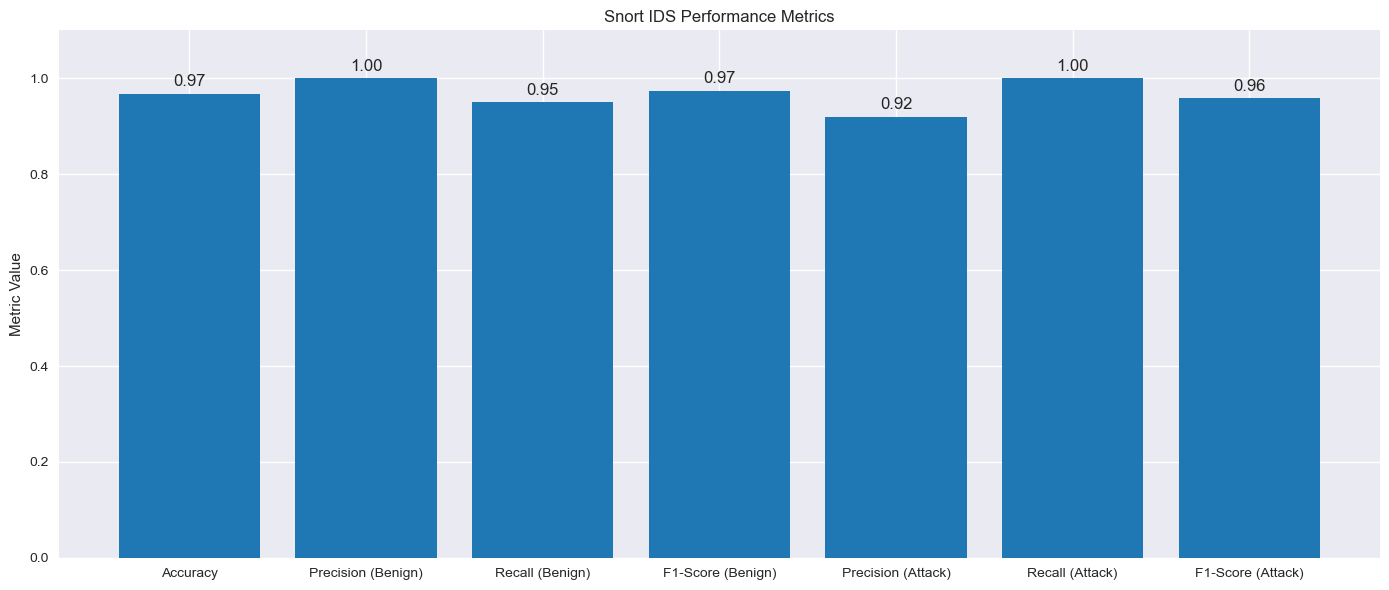


Confusion Matrix ----------------------
+----------------+----------------+----------------+------------+
|                |   Pred: Benign |   Pred: Attack |      Total |
+================+================+================+============+
| Actual: Benign |         417924 |          22107 |     440031 |
+----------------+----------------+----------------+------------+
| Actual: Attack |             37 |         252635 |     252672 |
+----------------+----------------+----------------+------------+


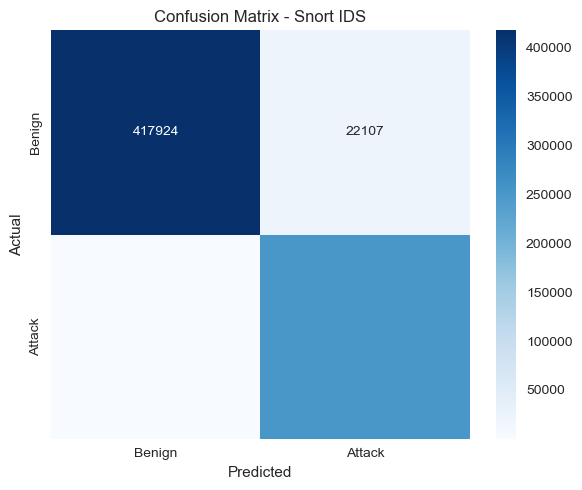


Files saved: 'snort_ids_performance_metrics.csv', 'snort_performance_metrics.png', 'snort_confusion_matrix.png'


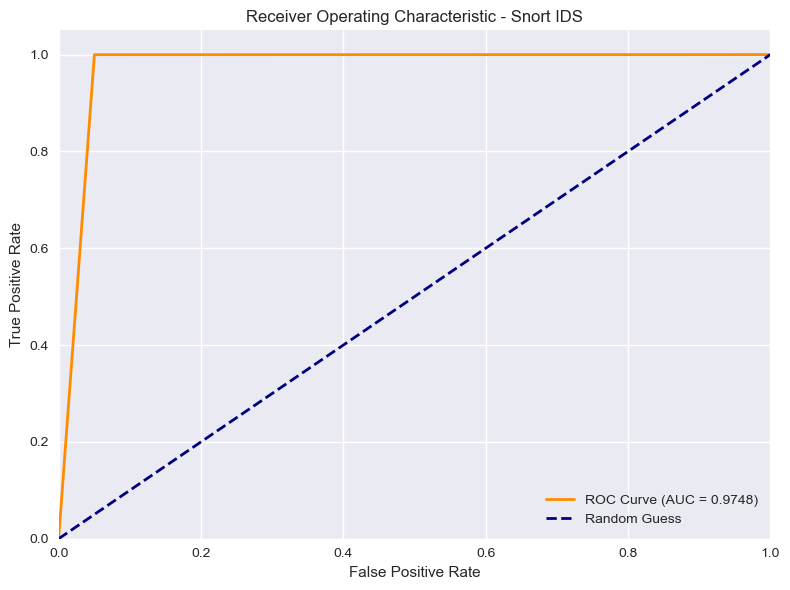


File saved: 'snort_roc_curve.png'


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 10})

# === File paths ===
alert_file = r"C:\Users\USER\Desktop\Capstone\GeneratedLabelledFlows\TrafficLabelling\IMP\SNORT\alert.csv"
true_labels_file = r"C:\Users\USER\Desktop\Capstone\GeneratedLabelledFlows\TrafficLabelling\IMP\SNORT\true_labels.csv"
gt_file = r"C:\Users\USER\Desktop\Capstone\GeneratedLabelledFlows\TrafficLabelling\IMP\SNORT\Wednesday-workingHours-preprocessed.csv"

# === Load alert.csv ===
num_cols = 27
col_names = [f"col{i}" for i in range(num_cols)]
alerts = pd.read_csv(alert_file, header=None, names=col_names)
alerts = alerts.rename(columns={
    "col5": "protocol",
    "col6": "src_ip",
    "col7": "src_port",
    "col8": "dst_ip",
    "col9": "dst_port"
})
proto_map = {'TCP': 6, 'UDP': 17}
alerts['protocol'] = alerts['protocol'].map(proto_map).fillna(alerts['protocol'])
alerts['src_ip'] = alerts['src_ip'].astype(str).str.strip()
alerts['dst_ip'] = alerts['dst_ip'].astype(str).str.strip()
alerts['src_port'] = pd.to_numeric(alerts['src_port'], errors='coerce').fillna(0).astype(int)
alerts['dst_port'] = pd.to_numeric(alerts['dst_port'], errors='coerce').fillna(0).astype(int)
alerts['protocol'] = alerts['protocol'].astype(str).str.strip()
alerts_key = alerts[['src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol']].drop_duplicates()

# === Load CICIDS ground truth (all flows) ===
gt = pd.read_csv(gt_file)
gt = gt.rename(columns={
    'Source IP': 'src_ip',
    'Source Port': 'src_port',
    'Destination IP': 'dst_ip',
    'Destination Port': 'dst_port',
    'Protocol': 'protocol',
    'Label': 'label'
})
gt['src_ip'] = gt['src_ip'].astype(str).str.strip()
gt['dst_ip'] = gt['dst_ip'].astype(str).str.strip()
gt['src_port'] = pd.to_numeric(gt['src_port'], errors='coerce').fillna(0).astype(int)
gt['dst_port'] = pd.to_numeric(gt['dst_port'], errors='coerce').fillna(0).astype(int)
gt['protocol'] = gt['protocol'].astype(str).str.strip()
gt = gt.merge(alerts_key, on=['src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol'], how='left', indicator=True)
gt['predicted'] = np.where(gt['_merge'] == 'both', 'ATTACK', 'BENIGN')
gt.drop(columns=['_merge'], inplace=True)

attack_keywords = ["DoS", "Heartbleed", "Web", "Botnet", "Brute", "Infiltration", "SQL", "XSS", "Attack"]
def map_truth(label):
    if pd.isna(label):
        return "BENIGN"
    for key in attack_keywords:
        if key.lower() in str(label).lower():
            return "ATTACK"
    return "BENIGN"
gt['true_class'] = gt['label'].apply(map_truth)

y_true = gt['true_class'].replace({'BENIGN': 0, 'ATTACK': 1}).values
y_pred = gt['predicted'].replace({'BENIGN': 0, 'ATTACK': 1}).values

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

metrics_order = [
    "Accuracy", "Precision (Benign)", "Recall (Benign)", "F1-Score (Benign)",
    "Precision (Attack)", "Recall (Attack)", "F1-Score (Attack)",
    "True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)", "True Positives (TP)"
]
sn_metrics = [
    accuracy_score(y_true, y_pred),
    report["0"]["precision"],
    report["0"]["recall"],
    report["0"]["f1-score"],
    report["1"]["precision"],
    report["1"]["recall"],
    report["1"]["f1-score"],
    tn, fp, fn, tp
]

metric_table = pd.DataFrame({"Metric": metrics_order, "Snort IDS": sn_metrics})
metric_table.to_csv("snort_ids_performance_metrics.csv", index=False)

# --- Print metrics table (vertical) ---
print(tabulate(metric_table, headers="keys", tablefmt="grid", floatfmt=".6f"))

# --- Bar graph visualization ---
plt.figure(figsize=(14,6))
bar_metrics = metrics_order[:7]
scores = [metric_table.loc[metric_table['Metric'] == m, "Snort IDS"].values[0] for m in bar_metrics]
colors = ["#1f77b4"] * 7
bars = plt.bar(bar_metrics, scores, color=colors)
plt.ylim(0, 1.1)
plt.ylabel("Metric Value")
plt.title("Snort IDS Performance Metrics")
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("snort_performance_metrics.png", dpi=300)
plt.show()

print("\nConfusion Matrix ----------------------")
cm_tab = [
    ["Actual: Benign", f"{cm[0,0]:>10}", f"{cm[0,1]:>10}", f"{cm[0].sum():>10}"],
    ["Actual: Attack", f"{cm[1,0]:>10}", f"{cm[1,1]:>10}", f"{cm[1].sum():>10}"]
]
print(tabulate([["", "Pred: Benign", "Pred: Attack", "Total"]] + cm_tab,
               headers="firstrow", tablefmt="grid"))

# --- Save confusion matrix visualization ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.title("Confusion Matrix - Snort IDS")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("snort_confusion_matrix.png")
plt.show()

print("\nFiles saved: 'snort_ids_performance_metrics.csv', 'snort_performance_metrics.png', 'snort_confusion_matrix.png'")

from sklearn.metrics import roc_curve, auc

# === Compute ROC Curve and AUC ===
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# === Plot ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Snort IDS")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("snort_roc_curve.png", dpi=300)
plt.show()

print("\nFile saved: 'snort_roc_curve.png'")

